In [22]:
from parcels import Field, FieldSet, ParticleSet, JITParticle, AdvectionRK4
%matplotlib inline
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
from datetime import timedelta

# A basic Parcels simulation

In [23]:
environmental_data_path = "/home/jennym/Environmental Data/Feb23/"

In [24]:
import os
print(os.path.exists(environmental_data_path))


True


### Initialise the FieldSet

In [25]:
filenames_current = environmental_data_path + "currents/trondheim_*.nc"
current_files = sorted(glob(filenames_current))

current_filename_map = {"U": current_files,
                        "V": current_files}
current_variables = {"U": "u_eastward",
                     "V": "v_northward" }
current_dimensions = {"lat": "lat",
             "lon": "lon",
             "time": "time"}


fieldset = FieldSet.from_netcdf(filenames=current_filename_map, variables=current_variables, dimensions=current_dimensions)


##### Visualise the FieldSet

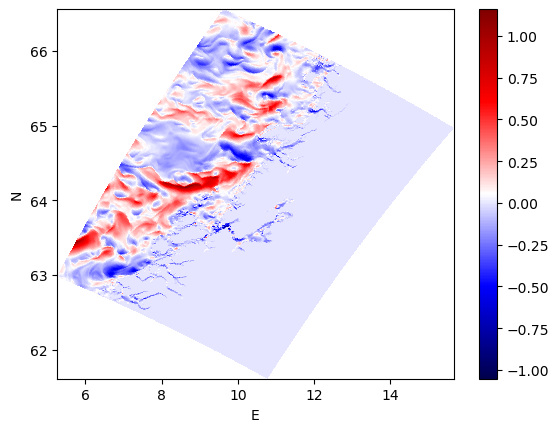

In [26]:
fieldset.computeTimeChunk()

plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0,:,:], cmap="seismic")
plt.xlabel("E")
plt.ylabel("N")
plt.colorbar()
plt.show()


#### Add wave data to FieldSet

In [27]:
filenames_wave = environmental_data_path + "waves/trondheim_*.nc"
wave_files = sorted(glob(filenames_wave))

wave_dimensions = {"lon": "longitude",
                   "lat": "latitude",
                  "time": "time"}

# Significant wave height Field
hs_variable = {"Wave_Hs": "hs"}
Hs_field = Field.from_netcdf(filenames=wave_files, variable=hs_variable, dimensions=wave_dimensions)


# Wave period Field
t_variable = {"Wave_T": "tp"}
T_field = Field.from_netcdf(filenames=wave_files, variable=t_variable, dimensions=wave_dimensions)


In [28]:
# Add the new Fields to the FieldSet
fieldset.add_field(Hs_field)
fieldset.add_field(T_field)

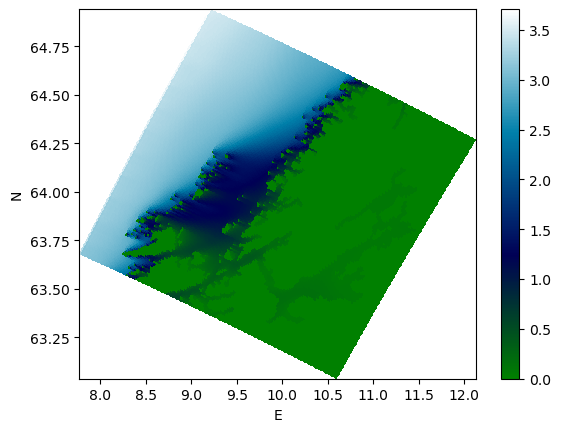

In [29]:
# Verify that it worked by visualising some of the wave data in the field
fieldset.computeTimeChunk()
plt.pcolormesh(fieldset.Wave_Hs.grid.lon, fieldset.Wave_Hs.grid.lat, fieldset.Wave_Hs.data[0,:,:], cmap="ocean")
plt.xlabel("E")
plt.ylabel("N")
plt.colorbar()
plt.show()

## Create a ParticleSet

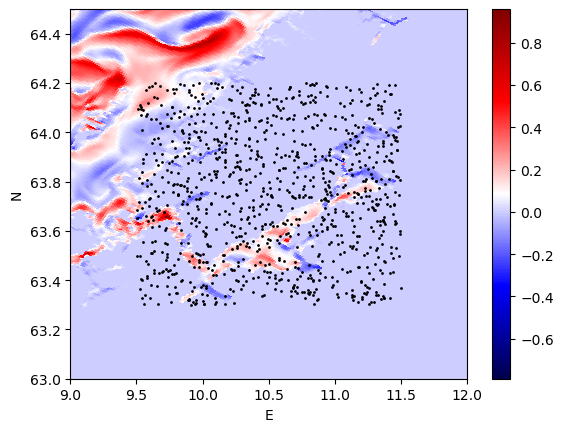

In [35]:
num_particles = 1000
pset = ParticleSet.from_list(fieldset=fieldset,
                             pclass=JITParticle,
                             lat=np.random.uniform(63.3, 64.2, size=num_particles),
                             lon=np.random.uniform(9.5, 11.5, size=num_particles))

# Show the particles in the U-field
plt.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0,:,:], cmap="seismic")
plt.xlabel("E")
plt.ylabel("N")
plt.colorbar()
plt.xlim(9,12)
plt.ylim(63,64.5)
plt.scatter(pset.lon, pset.lat, s=1, c="k")
plt.show()


## Run simulation

In [36]:
output_filename = "testsim.zarr"
output_file = pset.ParticleFile(name=output_filename,
                                outputdt=timedelta(minutes=60))

duration = 6
pset.execute(AdvectionRK4,
            runtime=timedelta(days=duration),
            dt=timedelta(minutes=5),
            output_file=output_file)

INFO: Output files are stored in testsim.zarr.
100%|██████████| 518400.0/518400.0 [00:29<00:00, 17651.51it/s]
